    Nama   : Ryan Rizky Fathinanto
    Email  : ryanrizkyf@gmail.com
    No. HP : 085692475682

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv('/content/GE.csv')
df.head()

Date      Open      High       Low     Close  Adj Close   Volume
0  1962-01-02  0.751202  0.763722  0.743690  0.748698   0.126780  2156544
1  1962-01-03  0.744942  0.744942  0.738682  0.741186   0.125508  1477632
2  1962-01-04  0.741186  0.747446  0.726162  0.732422   0.124024  1837056
3  1962-01-05  0.732422  0.733674  0.701122  0.713642   0.120844  2725632
4  1962-01-08  0.713642  0.713642  0.691106  0.712390   0.120632  3095040

In [3]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df

Date       Open       High  ...      Close  Adj Close    Volume
0      1962-01-02   0.751202   0.763722  ...   0.748698   0.126780   2156544
1      1962-01-03   0.744942   0.744942  ...   0.741186   0.125508   1477632
2      1962-01-04   0.741186   0.747446  ...   0.732422   0.124024   1837056
3      1962-01-05   0.732422   0.733674  ...   0.713642   0.120844   2725632
4      1962-01-08   0.713642   0.713642  ...   0.712390   0.120632   3095040
...           ...        ...        ...  ...        ...        ...       ...
14967  2021-06-17  13.410000  13.510000  ...  13.000000  13.000000  77013400
14968  2021-06-18  12.840000  13.020000  ...  12.780000  12.780000  81989800
14969  2021-06-21  12.890000  13.190000  ...  13.190000  13.190000  53954100
14970  2021-06-22  13.120000  13.200000  ...  13.030000  13.030000  38268600
14971  2021-06-23  13.020000  13.190000  ...  12.950000  12.950000  43585200

[14972 rows x 7 columns]

<Figure size 432x288 with 0 Axes>

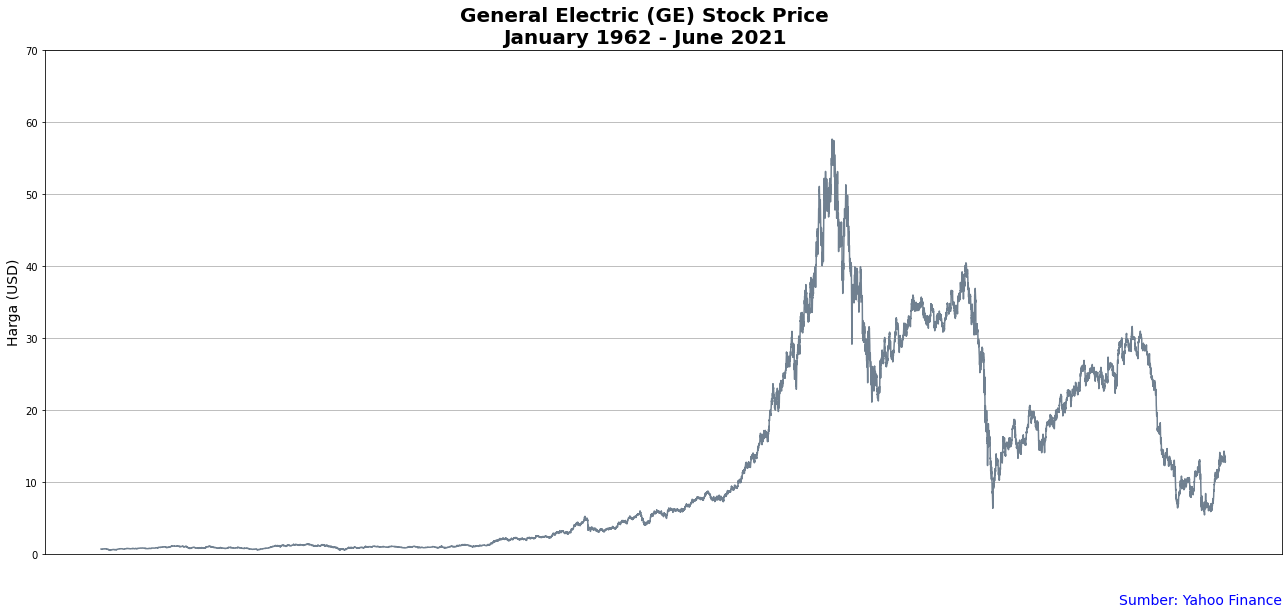

In [5]:
plt.clf()
fig, ax = plt.subplots(figsize=(18, 8))
plt.plot(df['Date'], df['Close'], color='slategray')
fig.suptitle('General Electric (GE) Stock Price\nJanuary 1962 - June 2021', 
             y=1.05, fontsize=20, fontweight='bold', ha='center')
ax.set_xlabel('')
ax.set_ylabel('Harga (USD)', fontsize=14)
ax.text(1, -0.1, 'Sumber: Yahoo Finance', color='blue',
        ha='right', transform=ax.transAxes, fontsize=14)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.grid(axis='y')
plt.ylim(ymin=0)
labels, locations = plt.yticks()
plt.yticks(labels, (labels).astype(int))
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Date'], df['Close'], test_size=0.2, shuffle=False)
print(len(X_train), len(X_test), len(y_train), len(y_test))

11977 2995 11977 2995


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
data_train = windowed_dataset(y_train, window_size=60, batch_size=32, shuffle_buffer=1000)
data_val = windowed_dataset(y_test, window_size=60, batch_size=32, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(1),
])

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nMAE telah mencapai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-04)

model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=optimizer,
              metrics=['mae'])

num_epochs=100
hist = model.fit(data_train,
                 epochs=num_epochs,
                 validation_data=(data_val),
                 callbacks=[callbacks],
                 batch_size=128)

Epoch 1/100
373/373 [==============================] - 18s 35ms/step - loss: 4.9938 - mae: 4.9938 - val_loss: 1.6212 - val_mae: 1.6212
Epoch 2/100
373/373 [==============================] - 12s 33ms/step - loss: 1.4017 - mae: 1.4017 - val_loss: 1.0342 - val_mae: 1.0342
Epoch 3/100
373/373 [==============================] - 12s 33ms/step - loss: 0.7229 - mae: 0.7229 - val_loss: 0.9154 - val_mae: 0.9154
Epoch 4/100
373/373 [==============================] - 12s 33ms/step - loss: 0.5099 - mae: 0.5099 - val_loss: 0.9004 - val_mae: 0.9004
Epoch 5/100
373/373 [==============================] - 12s 33ms/step - loss: 0.4104 - mae: 0.4104 - val_loss: 0.8344 - val_mae: 0.8344
Epoch 6/100
373/373 [==============================] - 12s 33ms/step - loss: 0.3577 - mae: 0.3577 - val_loss: 0.9724 - val_mae: 0.9724
Epoch 7/100
373/373 [==============================] - 12s 33ms/step - loss: 0.3263 - mae: 0.3263 - val_loss: 0.7008 - val_mae: 0.7008
Epoch 8/100
373/373 [==============================] - 

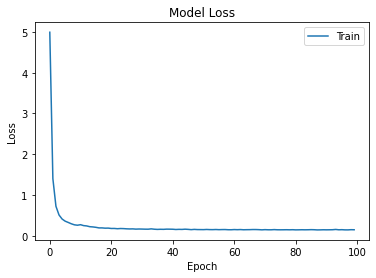

In [11]:
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()